### Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("employee-data/train.csv")

In [3]:
data_test = pd.read_csv("employee-data/test.csv")

In [4]:
data.shape

(22750, 9)

In [5]:
data.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [6]:
data_test.shape

(12250, 8)

In [7]:
data_test.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score'],
      dtype='object')

It appears that the test data does not contain a burn rate for each employee. In order to evaluate the performance of our model, we will work from only the labeled data (ie the training data).

Some general information about the each feature:

- Employee ID: The unique ID allocated for each employee (example: fffe390032003000)
- Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)
- Gender: The gender of the employee (Male/Female)
- Company Type: The type of company where the employee is working (Service/Product)
- WFH Setup Available: Is the work from home facility available for the employee (Yes/No)
- Designation: The designation of the employee of work in the organization. In the range of [0.0, 5.0] bigger is higher designation.
- Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource)
- Mental Fatigue Score: The level of fatigue mentally the employee is facing. In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
- Burn Rate: The value we need to predict for each employee telling the rate of Burnout while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [8]:
df = data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
Employee ID             22750 non-null object
Date of Joining         22750 non-null object
Gender                  22750 non-null object
Company Type            22750 non-null object
WFH Setup Available     22750 non-null object
Designation             22750 non-null float64
Resource Allocation     21369 non-null float64
Mental Fatigue Score    20633 non-null float64
Burn Rate               21626 non-null float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [10]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


We will first transform some of the data to make it more manageable to work with.

In [11]:
from datetime import datetime

In [12]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [13]:
today = datetime.today()

In [14]:
sec_yr = 365 * 24 * 60 * 60

In [15]:
df["Date of Joining"] = df["Date of Joining"].map(lambda date: datetime.strptime(date, "%Y-%m-%d"))

In [16]:
df["Years at Company"] = df["Date of Joining"].map(lambda date: round(((today - date).total_seconds()/sec_yr), 2))

In [17]:
df.drop(columns = ["Date of Joining", "Employee ID"], inplace=True)

In [18]:
cols = ['Years at Company','Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']
df = df[cols]

In [19]:
df.rename(columns={"Burn Rate": "Burnout Level"}, inplace=True)

In [20]:
df.duplicated().sum()

41

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
df.isna().sum()

Years at Company           0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1380
Mental Fatigue Score    2110
Burnout Level           1122
dtype: int64

It appears that there are missing values for the predictors Resource Allocation and Mental Fatigue Score, and for the target class Burnout Level. We will drop the missing data from Burnout Level and impute values (using the median) for the other two predictors for our initial model.

In [23]:
df.dropna(subset = ["Burnout Level"], inplace=True)

In [24]:
med_ra = df["Resource Allocation"].median()
med_mf = df["Mental Fatigue Score"].median()

In [25]:
df["Resource Allocation"].fillna(value = med_ra, inplace=True)
df["Mental Fatigue Score"].fillna(value = med_mf, inplace=True)

In [26]:
df.isna().sum().sum()

0

In [27]:
df_pre = df

Since our model will apply classification algorithms, we will convert the burn rate columns into discrete classes of 1-5, with 1 being the lowest and 5 being the highest in terms of burnout.

In [28]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 5 if (rate > 0.8 and rate <= 1) else rate)

In [29]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 4 if (rate > 0.6 and rate <= 0.8) else rate)

In [30]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 3 if (rate > 0.4 and rate <= 0.6) else rate)

In [31]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 2 if (rate > 0.2 and rate <= 0.4) else rate)

In [32]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 1 if rate <= 0.2 else rate)

In [33]:
df_pre["Burnout Level"].value_counts(normalize=True)

3.0    0.369852
2.0    0.296892
4.0    0.183629
1.0    0.110807
5.0    0.038820
Name: Burnout Level, dtype: float64

In [34]:
df_pre.head()

,Years at Company,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
0,12.24,Female,Service,No,2.0,3.0,3.8,1.0
1,12.07,Male,Service,Yes,1.0,2.0,5.0,2.0
2,12.80,Female,Product,Yes,2.0,4.0,5.8,3.0
3,12.14,Male,Service,Yes,1.0,1.0,2.6,1.0
4,12.42,Female,Service,No,3.0,7.0,6.9,3.0


### Exploratory Data Analysis

Now that we have done some initial data cleaning, we can begin the process of EDA

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("notebook")
sns.set_palette("Spectral")
fs = (10, 10)
fss = (5, 5)
fs_long = (10, 15)
fs_wide = ((15, 10))

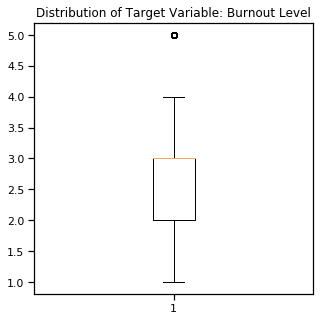

In [36]:
plt.figure(figsize=fss)
plt.boxplot(df_pre["Burnout Level"], showfliers=True)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

<Figure size 360x360 with 0 Axes>

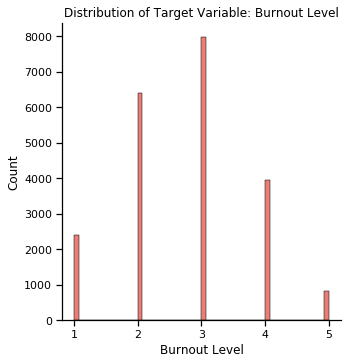

In [37]:
plt.figure(figsize=fss)
sns.displot(df_pre["Burnout Level"], kde=False)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

Target variable is fairly normally distributed, with most instances falling into the burnout category of 3, and less in the two extremes of 1 and 5.

In [38]:
df_num = df_pre[["Years at Company", "Designation", "Resource Allocation", "Mental Fatigue Score"]]

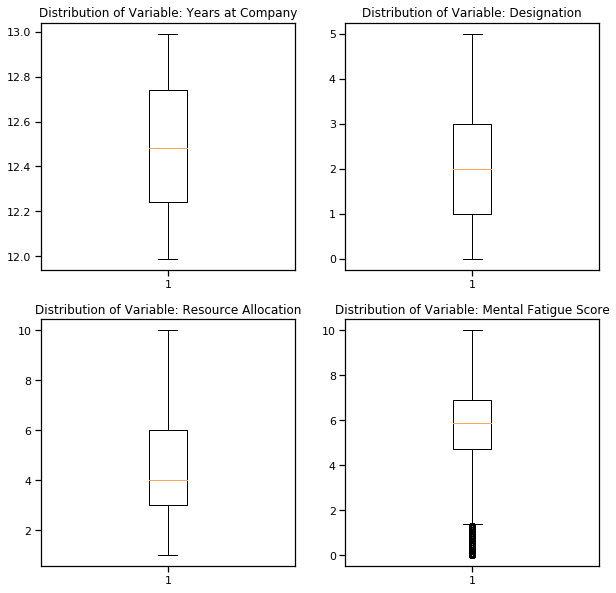

In [39]:
fig, axs = plt.subplots(2,2, figsize=(fs))
axs = axs.ravel()

for i in range(4):

    axs[i].boxplot(df_num.iloc[:, i], showfliers=True)
    axs[i].set_title("Distribution of Variable: " + str(df_num.iloc[:, i].name))

There appears to be some lower outliers in mental fatigue score. 

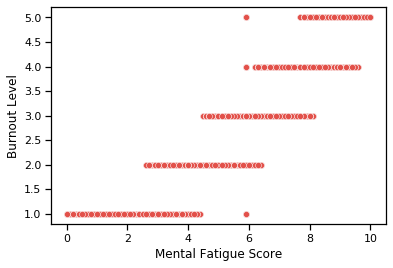

In [40]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"])
plt.show()

Mental fatigue score appears to be positively correlated with Burnout Level (ie as mental fatigue increases, burnout also tends to increase).

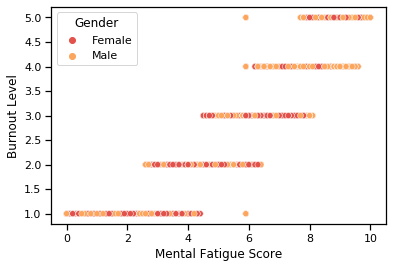

In [41]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"], hue=df_pre["Gender"])
plt.show()

In [42]:
df_pre["Gender"].value_counts(normalize=True)

Female    0.524343
Male      0.475657
Name: Gender, dtype: float64

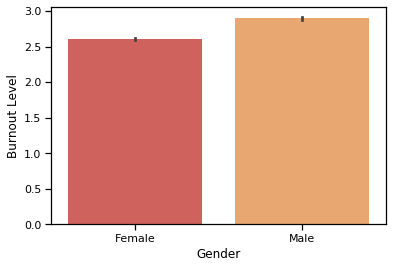

In [43]:
sns.barplot(x=df_pre["Gender"], y=df_pre["Burnout Level"])
plt.show()

It appears that men had slightly higher burnout levels on average.

In [44]:
df_pre.groupby(["Gender"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
Gender,,,,,
Female,12.48,2.0,4.0,5.8,3.0
Male,12.48,2.0,5.0,6.0,3.0


However, the medians both appear to converge at 3 for both males and females.

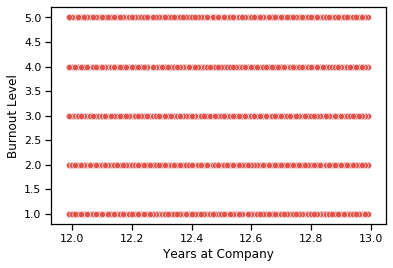

In [45]:
sns.scatterplot(x=df_pre["Years at Company"], y=df_pre["Burnout Level"])
plt.show()

There doesn't appear to be much of an influence from years at the company on burnout level, although this may be due to the fact that there is not much variation in terms of years worked.

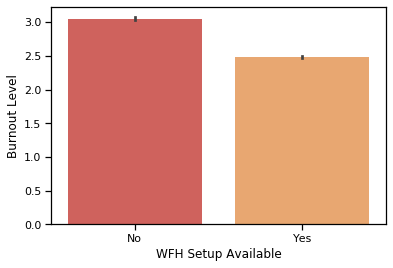

In [46]:
sns.barplot(x=df_pre["WFH Setup Available"], y=df_pre["Burnout Level"])
plt.show()

Not having a work from home setup appeared to correlate to higher burnout levels on average.

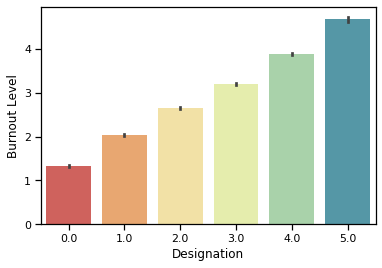

In [47]:
sns.barplot(x=df_pre["Designation"], y=df_pre["Burnout Level"])
plt.show()

Higher designations (Higher positions) appeared to also correlate positively to higher burnout levels.

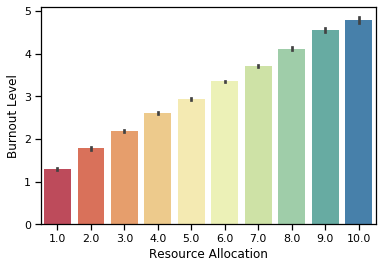

In [48]:
sns.barplot(x=df_pre["Resource Allocation"], y=df_pre["Burnout Level"], palette = "Spectral")
plt.show()

Higher resource allocation (ie more working hours) appears to also correlate positively with higher burnout. 

After doing some initial investigation, it appears employee burnout is greater in males, those who hold higher positions, and those who are allocated more working hours. It also seems that employees without a functioning WFH setup have a higher burnout level on average.

In [49]:
df_pre.groupby(["Burnout Level"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score
Burnout Level,,,,
1.0,12.475,1.0,2.0,2.5
2.0,12.480,2.0,3.0,4.7
3.0,12.480,2.0,5.0,6.2
4.0,12.490,3.0,6.0,7.7
5.0,12.490,4.0,8.0,9.1


In [50]:
high_burn = df_pre.loc[(df_pre["Burnout Level"] == 4) | (df_pre["Burnout Level"] == 5)]

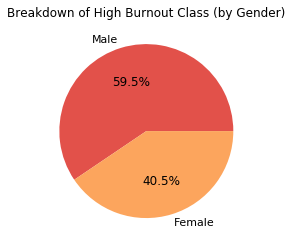

In [51]:
sizes = high_burn["Gender"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Gender)")
plt.show()

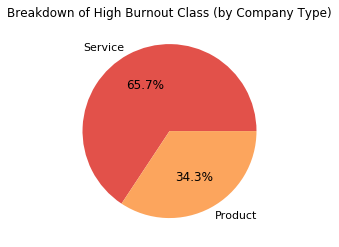

In [52]:
sizes = high_burn["Company Type"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Company Type)")
plt.show()

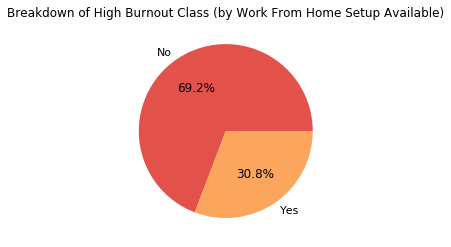

In [53]:
sizes = high_burn["WFH Setup Available"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Work From Home Setup Available)")
plt.show()

Of the highest burnout classes (level 4 and 5), 60% were male, 66% worked in a service oriented company, and 70% did not have a WFH setup available.

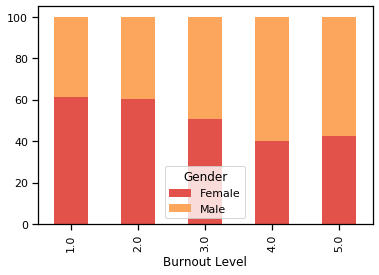

In [54]:
gr = df_pre.groupby('Burnout Level')['Gender'].value_counts(normalize=True).mul(100)
gr.unstack().plot.bar(stacked=True)

In [55]:
df_cat = df_pre[["Gender", "Company Type", "WFH Setup Available", "Designation", "Resource Allocation", "Burnout Level"]]

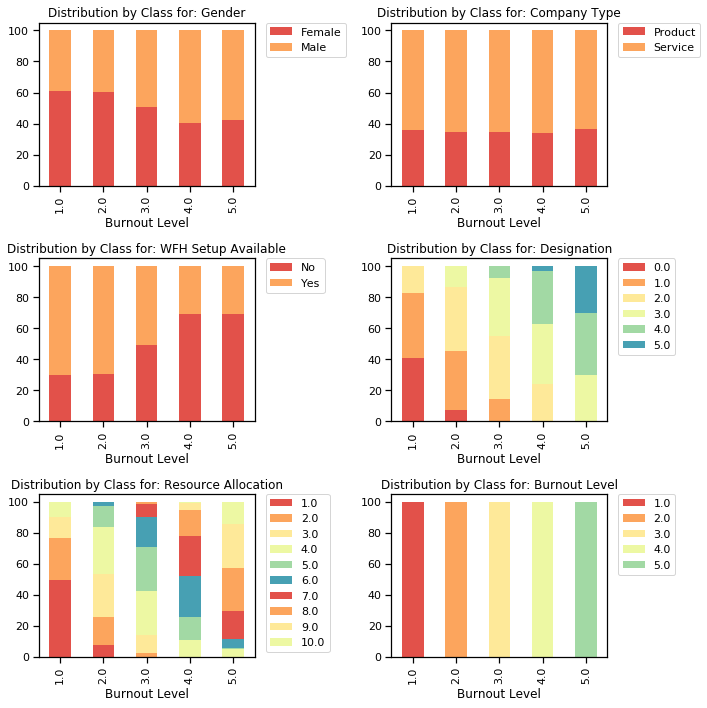

In [56]:
fig, axs = plt.subplots(3,2, figsize=fs)
axs = axs.ravel()

for i, ax in enumerate(axs):
    
    grp_obj = df_cat.groupby("Burnout Level")[df_cat.iloc[:, i].name].value_counts(normalize=True).mul(100)
    grp_obj.unstack().plot.bar(stacked=True, ax=ax)
    ax.set_title("Distribution by Class for: " + str(df_cat.iloc[:, i].name))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()


Here we can further see how the distributions of our predictors change between classes

### Modeling

We will now apply various classification algorithms to the cleaned dataset. The target is to classify employees in one of the 5 burnout levels based on the other predictor variables. We will first run multiple "vanilla" models to get a baseline. Some of the algorithms we will apply are:

- Logistic Regression
- K Nearest Neighbors (KNN)
- Bayes Classification
- Decision Trees
- Ensemble Methods
- SVM

#### Data Preparation

We will begin by creating dummy variables for our categorical variables so the data can be read by the various algorithms. 

In [57]:
y = df_pre["Burnout Level"]
X = df_pre.drop(columns = "Burnout Level", axis = 1)

In [58]:
X.head()

,Years at Company,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,12.24,Female,Service,No,2.0,3.0,3.8
1,12.07,Male,Service,Yes,1.0,2.0,5.0
2,12.80,Female,Product,Yes,2.0,4.0,5.8
3,12.14,Male,Service,Yes,1.0,1.0,2.6
4,12.42,Female,Service,No,3.0,7.0,6.9


In [59]:
X = pd.get_dummies(X, columns = ["Gender", "Company Type", "WFH Setup Available"])

We will now split our data into training and testing data, so we can measure the accuracy of our model on "new" data.

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

#### Metrics and Functions

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

In [62]:
cmap = "plasma"

In [63]:
def return_metrics(actual, preds):
    df = pd.DataFrame(classification_report(actual, preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    return df

In [64]:
def fit_return_metrics(model, X_train, y_train, X_test, y_test):
    modelf = model.fit(X_train, y_train)
    train_preds = modelf.predict(X_train)
    test_preds = modelf.predict(X_test)
    df_tr = pd.DataFrame(classification_report(y_train, train_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    df_ts = pd.DataFrame(classification_report(y_test, test_preds, output_dict=True)).transpose().apply(lambda x: round(x, 2))
    print("Training Metrics: \n" + str(df_tr) + "\n")
    print("Test Metrics: \n" + str(df_ts))
    return df_tr, df_ts

In [65]:
def return_conf_matrix(model, X_train, y_train, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(fs_wide))
    conf_tr = plot_confusion_matrix(model, X_train, y_train, ax = ax1, cmap=cmap)
    ax1.set_title("Training Matrix")
    conf_ts = plot_confusion_matrix(model, X_test, y_test, ax = ax2, cmap=cmap)
    ax2.set_title("Test Matrix")
    plt.tight_layout()
    plt.show()

#### Baseline Models

##### Logistic Regression

Logistic regression uses an S shaped log function to represent the relationships between certain features and the determination of class.

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [67]:
scaled_pipeline_log = Pipeline([("ss", StandardScaler()),
                             ("lr", LogisticRegression())])

In [68]:
lg_tr1, lg_ts1 = fit_return_metrics(scaled_pipeline_log, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.82    0.71      0.76   1758.00
2.0                0.74    0.74      0.74   4820.00
3.0                0.70    0.76      0.73   6010.00
4.0                0.69    0.67      0.68   2983.00
5.0                0.74    0.49      0.59    619.00
accuracy           0.72    0.72      0.72      0.72
macro avg          0.74    0.67      0.70  16190.00
weighted avg       0.72    0.72      0.72  16190.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.85    0.71      0.77   634.00
2.0                0.74    0.74      0.74  1589.00
3.0                0.70    0.76      0.73  1974.00
4.0                0.68    0.67      0.68   981.00
5.0                0.82    0.49      0.62   219.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.76    0.68      0.71  5397.00
weighted avg       0.73    0.72      0.72  5397.00


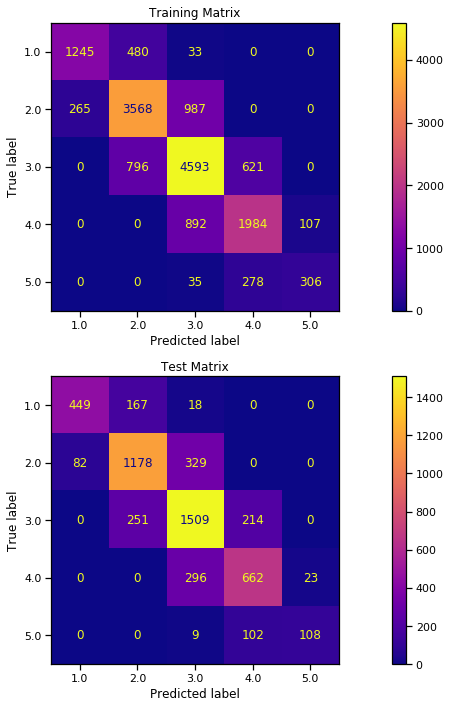

In [69]:
return_conf_matrix(scaled_pipeline_log, X_train, y_train, X_test, y_test)

Vanilla logistic regression model has fair accuracy (72% of all predictions were correctly classified for level of burnout). Precision overall scored similar (On average, out of all the times the model predicted that the person would have a burnout level of X, 73% actually had that level of burnout). Recall also had a score of 72% (On average, out of all the actual instances with a burnout level of X, our model predicted that burnout level 72% of the time). Precision and recall is fairly balanced in this first case (not skewed towards False Positives or False Negatives), as evidenced by the F1 score of 72%.

However, when we look at the metrics for each class, we see that the model has trouble discerning between the higher burnout levels. For example, level 5 (high burnout) had a recall of 49% (meaning that out of all the people who actually scored a 5, our model only predicted 5 49% of the time). This could mean that our model is not discerning enough between the higher classes, and is currently tuned to minimize instances of False Positives for level 5 (FP = Saying someone has level 5 burnout when in reality they do not) more than it should be - so the model is not conservative enough. This could be an issue of class imbalance, since level 5 burnout only accounts for 3% of the dataset. 

##### KNN

KNN assumes that the smaller distance between points, the more similar they are. Therefore, a point with certain features and in a certain class, should have the same class as a point with similar features. All the point features are simply stored (as a map of "coordinates") in the training step, and then during testing distances between testing and training coordinates are calculated to determine which class the testing point is in (based on the classes of the nearest points).

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
scaled_pipeline_knn = Pipeline([("ss", StandardScaler()),
                             ("knn", KNeighborsClassifier())])

In [73]:
kn_tr1, kn_ts1 = fit_return_metrics(scaled_pipeline_knn, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.89    0.78      0.83   1758.00
2.0                0.79    0.82      0.81   4820.00
3.0                0.77    0.82      0.79   6010.00
4.0                0.77    0.71      0.74   2983.00
5.0                0.84    0.59      0.69    619.00
accuracy           0.79    0.79      0.79      0.79
macro avg          0.81    0.75      0.77  16190.00
weighted avg       0.79    0.79      0.79  16190.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.85    0.72      0.78   634.00
2.0                0.70    0.72      0.71  1589.00
3.0                0.66    0.72      0.69  1974.00
4.0                0.64    0.61      0.63   981.00
5.0                0.71    0.45      0.55   219.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.71    0.64      0.67  5397.00
weighted avg       0.69    0.69      0.69  5397.00


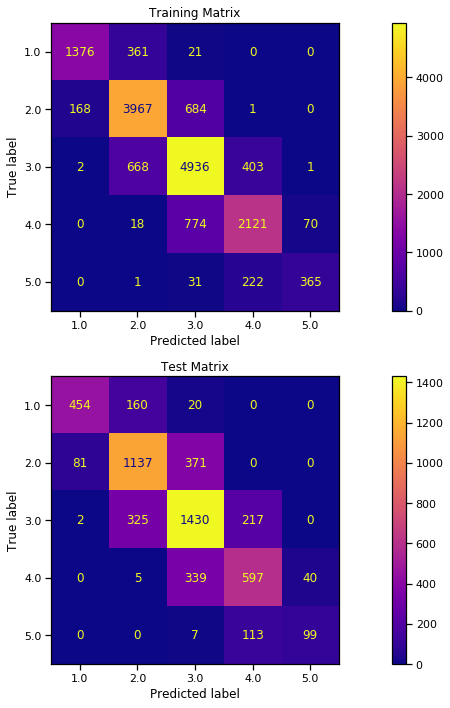

In [74]:
return_conf_matrix(scaled_pipeline_knn, X_train, y_train, X_test, y_test)

This vanilla KNN model appears to perform slightly better than the logistic regression algorithm, but only on the training set. This could signify that the current parameters of the KNN model overfit the model to the training set.

##### Bayes Classification

Bayes Classification looks to predict a class based on certain information, which can be visualized through conditional probability. Assuming the predictors are independent, one can estimate the overall probability of being in one class versus another by multiplying the conditional probabilities of the predictors together. The class with the highest probability becomes the class predicted.

In [76]:
from sklearn.naive_bayes import GaussianNB

In [77]:
scaled_pipeline_bay = Pipeline([("ss", StandardScaler()),
                             ("bay", GaussianNB())])

In [78]:
by_tr1, by_ts1 = fit_return_metrics(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.74    0.77      0.75   1758.00
2.0                0.71    0.71      0.71   4820.00
3.0                0.71    0.67      0.69   6010.00
4.0                0.63    0.67      0.65   2983.00
5.0                0.63    0.62      0.62    619.00
accuracy           0.69    0.69      0.69      0.69
macro avg          0.68    0.69      0.69  16190.00
weighted avg       0.69    0.69      0.69  16190.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.75    0.76      0.75   634.00
2.0                0.70    0.70      0.70  1589.00
3.0                0.70    0.67      0.68  1974.00
4.0                0.62    0.67      0.64   981.00
5.0                0.65    0.61      0.63   219.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.68    0.68      0.68  5397.00
weighted avg       0.69    0.69      0.69  5397.00


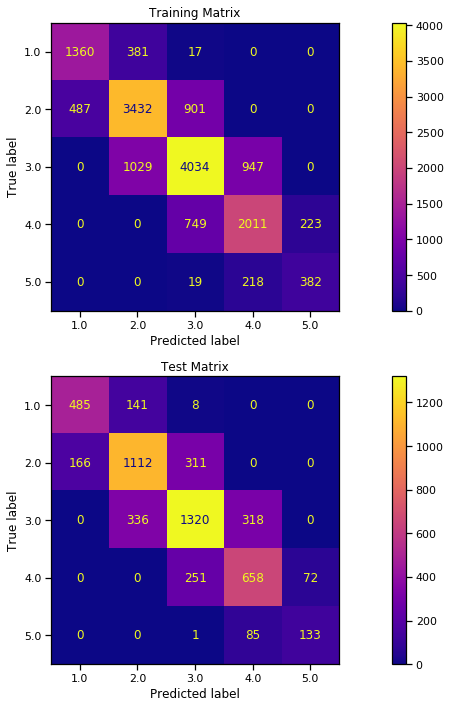

In [79]:
return_conf_matrix(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

The model performed similarly on the training and testing data (overall accuracy of 69%), but similar to the other models, loses some predictability when it comes to the higher classes (level 4 and 5 burnout).

##### Decision Trees

Decision trees are their own classifier and make up the base structure for many ensemble methods. Trees have nodes that partition the sample space into two or more subspaces (branches). Each node considers a different predictor. The training set is used to construct the tree (using the GINI idx as a cost function to minimize). Then each test point is run through the trained tree, where it ends at a leaf node that classifies it.

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
scaled_pipeline_dtr = Pipeline([("ss", StandardScaler()),
                             ("dt", DecisionTreeClassifier(criterion="gini"))])

In [82]:
dt_tr1, dt_ts1 = fit_return_metrics(scaled_pipeline_dtr, X_train, y_train, X_test, y_test)

Training Metrics: 
              precision  recall  f1-score   support
1.0                0.99    1.00      1.00   1758.00
2.0                0.98    1.00      0.99   4820.00
3.0                0.99    0.99      0.99   6010.00
4.0                1.00    0.99      0.99   2983.00
5.0                1.00    0.99      1.00    619.00
accuracy           0.99    0.99      0.99      0.99
macro avg          0.99    0.99      0.99  16190.00
weighted avg       0.99    0.99      0.99  16190.00

Test Metrics: 
              precision  recall  f1-score  support
1.0                0.76    0.76      0.76   634.00
2.0                0.67    0.67      0.67  1589.00
3.0                0.66    0.66      0.66  1974.00
4.0                0.61    0.62      0.61   981.00
5.0                0.65    0.62      0.63   219.00
accuracy           0.66    0.66      0.66     0.66
macro avg          0.67    0.66      0.66  5397.00
weighted avg       0.66    0.66      0.66  5397.00


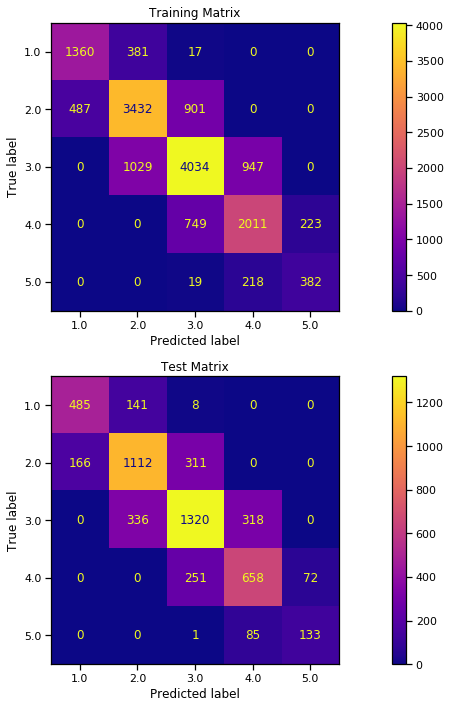

In [83]:
return_conf_matrix(scaled_pipeline_bay, X_train, y_train, X_test, y_test)

The decision tree classifier performed very well on the training data (almost perfect accuracy) but has clearly overfit to the data, as evidenced by the much poorer performance on the testing data (66% overall accuracy).